In [44]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import pickle
import gzip
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.utils import np_utils
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from PIL import Image
import os
import itertools
import seaborn as sn

In [45]:
def plot_confusion_matrix(TestingTarget, y_pred):

    arr = confusion_matrix(TestingTarget, y_pred)
    xticks = np.arange(10)
    yticks = np.arange(10)

    plt.figure(figsize = (10,7))
    sn.heatmap(arr, annot=True, fmt="d",cmap="Blues", xticklabels=xticks, yticklabels=yticks)
    
    
def plot_classification_report(TestingTarget, y_pred):
    plt.figure(figsize=(10,7))

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = ['0','1', '2', '3' ,'4', '5', '6', '7', '8', '9', 'average']

    rep = np.array(precision_recall_fscore_support(TestingTarget, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    t_rep = rep.T
    vmin = min(np.min(t_rep[0]), np.min(t_rep[1]), np.min(t_rep[2]))
    vmax = max(np.max(t_rep[0]), np.max(t_rep[1]), np.max(t_rep[2]))

    sn.heatmap(rep,
            annot=True, 
            cbar=True, 
            xticklabels=xticks, 
            yticklabels=yticks,fmt=".2f",cmap="OrRd",vmin=vmin, vmax=vmax)

# Pre-process: MNIST DATA

In [46]:
filename = 'mnist.pkl.gz'
f = gzip.open(filename, 'rb')
__training_data, __validation_data, __test_data = pickle.load(f, encoding='latin1')
f.close()

TrainingData = __training_data[0]
TrainingTarget = __training_data[1]

ValidationData = __validation_data[0]
ValidationTarget = __validation_data[1]

TestingData = __test_data[0]
TestingTarget = __test_data[1]


print("=========================")
print("== MNIST Dataset ==")
print("=========================")
print("TrainingData : " + str(TrainingData.shape))
print("TrainingTarget : " + str(TrainingTarget.shape))
print("ValidationData : " + str(ValidationData.shape))
print("ValidationTarget : " + str(ValidationTarget.shape))
print("TestingData : " + str(TestingData.shape))
print("TestingTarget : " + str(TestingTarget.shape))

== MNIST Dataset ==
TrainingData : (50000, 784)
TrainingTarget : (50000,)
ValidationData : (10000, 784)
ValidationTarget : (10000,)
TestingData : (10000, 784)
TestingTarget : (10000,)


# Pre-process: USPS Data

In [47]:
USPSMat  = []
USPSTar  = []
curPath  = 'USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

USPS_Testing_data = np.asarray(USPSMat)
USPS_Testing_target = np.asarray(USPSTar)

print("=========================")
print("==== USPS Dataset ==")
print("=========================")
print("USPS_Testing_data : " + str(USPS_Testing_data.shape))
print("USPS_Testing_target : " + str(USPS_Testing_target.shape))

==== USPS Dataset ==
USPS_Testing_data : (19999, 784)
USPS_Testing_target : (19999,)


#  Definition: Mini-batch Stochastic Gradient Descent

In [71]:
class MiniBatchSGD:
    def __init__(self, _no_of_classes =10,_learning_rate = 0.05, _mini_batch=32):
        self.no_of_classes = _no_of_classes
        self.learning_rate = _learning_rate
        self.mini_batch = _mini_batch
        
    def softmax(self, z):
    
        numerator = np.exp (z)
        demominator =  np.exp(z).sum(axis=0)

        return numerator/demominator
        
    def train_model(self, _TrainingData, _TrainingTarget, _loop_range):
        
        
        no_of_samples = _TrainingData.shape[0]
        
        bias = np.ones([no_of_samples,1])
        
        _TrainingData = np.concatenate((_TrainingData, bias), axis=1)
        
#         print(_TrainingData.shape)
        no_of_features = _TrainingData.shape[1]
        
        
        
        W = np.ones([no_of_features, self.no_of_classes])
        W_NOW = np.transpose(W)

        _TrainingTargetVector =  (np.arange(np.max(_TrainingTarget) + 1) == _TrainingTarget[:, None]).astype(float)

        _loop_range = min(_loop_range, (int) (no_of_samples/self.mini_batch))


        for i in range(_loop_range):

            lowerbound = i*self.mini_batch
            upperbound = min(no_of_samples, (i+1)*self.mini_batch)

            _thisTrainData = _TrainingData[lowerbound:upperbound].T

            z = np.dot(W_NOW, _thisTrainData)
            predicted_values = self.softmax(z).T


            diff = np.subtract(predicted_values, _TrainingTargetVector[lowerbound:upperbound])


            _thisTrainData = _thisTrainData.reshape(no_of_features, self.mini_batch)
            diff = diff.reshape(self.mini_batch, self.no_of_classes)

            Delta_W = np.dot(_thisTrainData, diff)

            W_NOW = W_NOW - (self.learning_rate*Delta_W.T)
        
        self.weights = W_NOW
        
    def get_prediction(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred.argmax(axis=0).T
    
    def get_prediction_probability(self, _data):
        
        no_of_samples = _data.shape[1]
        
        bias = np.ones([1, no_of_samples])
        _data = np.concatenate((_data, bias), axis=0)
        
        y_pred   = self.softmax(np.dot(self.weights, _data))
        return y_pred
             
    def get_accuracy(self, _data, _target):
        
        accuracy = 0.0
        counter = 0
        
        pred_data = self.get_prediction(_data)

        for i in range (0,len(pred_data)):
            if(int(pred_data[i]) == _target[i]):
                counter+=1
        accuracy = (float((counter*100))/float(len(pred_data)))
        return accuracy



====== MNIST Dataset =====
Training Accuracy :89.44
Validation Accuracy :90.51
Testing Accuracy :89.97


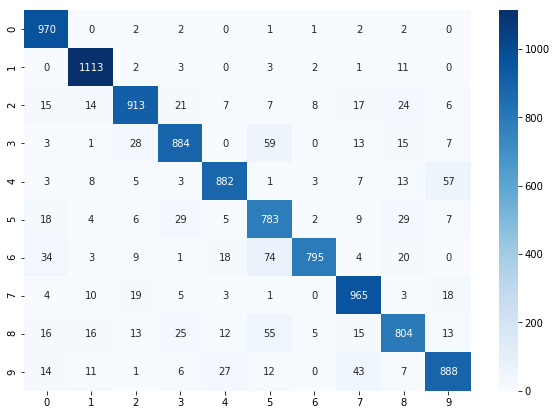

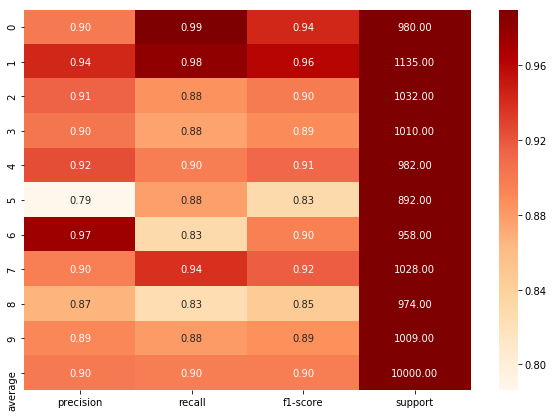

In [73]:
mini_batch_sgd = MiniBatchSGD(_no_of_classes =10,_learning_rate = 0.05, _mini_batch=50)
mini_batch_sgd.train_model(TrainingData, TrainingTarget, 1000)


%matplotlib inline

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")

print("Training Accuracy :" + str(mini_batch_sgd.get_accuracy(TrainingData.T, TrainingTarget)))
print("Validation Accuracy :" + str(mini_batch_sgd.get_accuracy(ValidationData.T, ValidationTarget)))

lr_testing_acc = mini_batch_sgd.get_accuracy(TestingData.T, TestingTarget)
print("Testing Accuracy :" + str(lr_testing_acc))


y_pred = mini_batch_sgd.get_prediction(TestingData.T)

plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)




====== USPS Dataset =====
Testing Accuracy :32.51662583129156


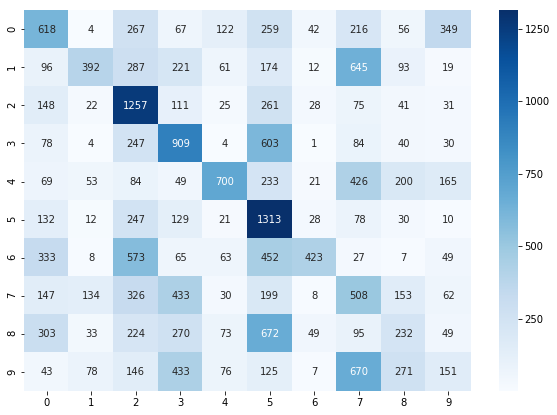

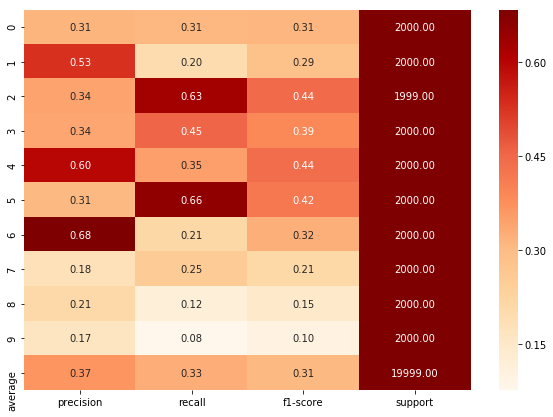

In [84]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")

usps_lr_testing_acc = mini_batch_sgd.get_accuracy(USPS_Testing_data.T, USPS_Testing_target)
print("Testing Accuracy :" + str(usps_lr_testing_acc))

y_pred = mini_batch_sgd.get_prediction(USPS_Testing_data.T)       

plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Neural Network

In [51]:
class NeuralNetwork:
    
    def __init__(self, input_size, drop_out, dl_1_nodes, dl_2_nodes, dl_3_nodes, 
                 opt = 'adam', loss_func = 'binary_crossentropy'):
        
        self.model = Sequential()
    
        self.model.add(Dense(dl_1_nodes, input_dim=input_size))
        self.model.add(Activation('relu'))

        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_2_nodes))
        self.model.add(Activation('relu'))


        self.model.add(Dropout(drop_out))

        self.model.add(Dense(dl_3_nodes))
        self.model.add(Activation('softmax'))


        self.model.summary()

        self.model.compile(optimizer=opt,
                      loss= loss_func,
                      metrics=['accuracy'])
        
        
    def train_model(self, RawData, RawTarget, ValidationData, ValTargetVector, 
                    num_epochs = 10000, model_batch_size = 128, tb_batch_size = 32, early_patience = 15):
        
        tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)

        earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

        TargetVector = np_utils.to_categorical(np.array(RawTarget), 10)

        ValTargetVector = np_utils.to_categorical(np.array(ValidationTarget), 10)


        self.history = self.model.fit(RawData
                            , TargetVector
                            , validation_data = (ValidationData, ValTargetVector)
                            , epochs=num_epochs
                            , batch_size=model_batch_size
                            , callbacks = [tensorboard_cb,earlystopping_cb]
                           )
    def plot_history(self):
        %matplotlib inline

        df = pd.DataFrame(self.history.history)
        df.plot(subplots=True, grid=True, figsize=(10,15))
        
    def get_prediction(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        prediction_classes = prediction.argmax(axis=-1)
        return prediction_classes
    
    def get_prediction_probability(self, TestingData):
        
        prediction = self.model.predict(TestingData)
        return prediction
        
    def get_accuracy(self, TestingData, TestingTarget):
        
        prediction_classes = self.get_prediction(TestingData)
        score = accuracy_score(TestingTarget, prediction_classes)
        return score
        

In [65]:
neural_network = NeuralNetwork(input_size = TrainingData.shape[1], drop_out = 0.2, dl_1_nodes =512, dl_2_nodes =256, dl_3_nodes =10, 
                 opt = 'adam', loss_func = 'categorical_crossentropy')


neural_network.train_model(TrainingData, TrainingTarget, ValidationData, ValidationTarget)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                2570      
__________

====== MNIST Dataset =====
Training Accuracy :0.99924
Validation Accuracy :0.9828
Testing Accuracy :0.9817


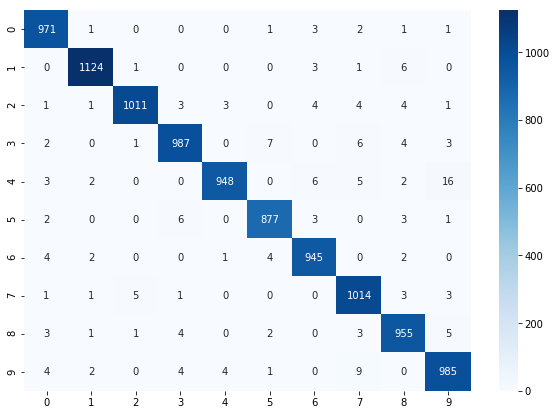

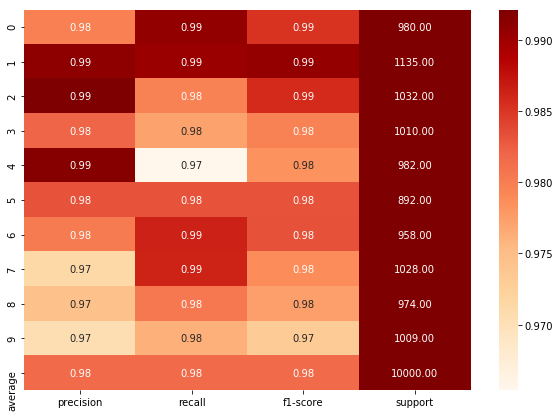

In [74]:
# neural_network.plot_history()

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


print("Training Accuracy :" + str(neural_network.get_accuracy(TrainingData, TrainingTarget)))
print("Validation Accuracy :" + str(neural_network.get_accuracy(ValidationData, ValidationTarget)))

nn_testing_acc = neural_network.get_accuracy(TestingData, TestingTarget)
print("Testing Accuracy :" + str(nn_testing_acc))


y_pred = neural_network.get_prediction(TestingData)
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)


====== USPS Dataset =====
Testing Accuracy :0.4995249762488124


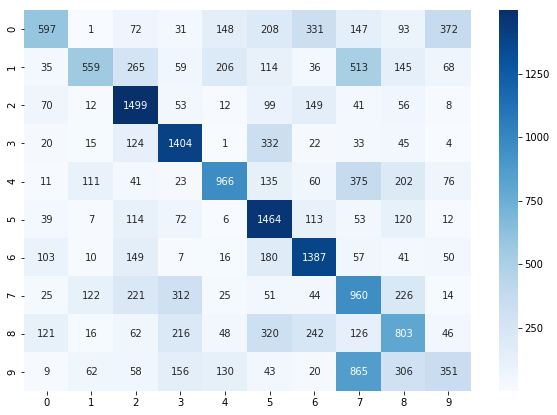

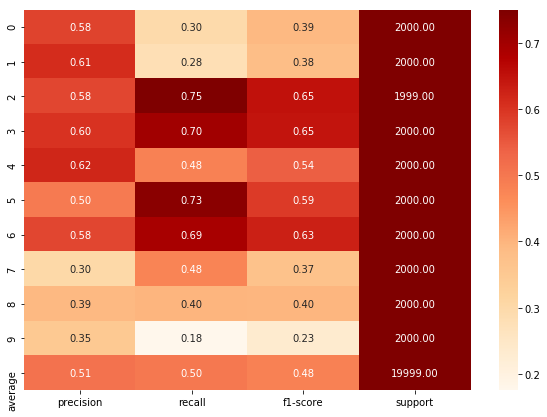

In [76]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")


usps_nn_testing_acc = neural_network.get_accuracy(USPS_Testing_data, USPS_Testing_target)
print("Testing Accuracy :" + str(usps_nn_testing_acc))


y_pred = neural_network.get_prediction(USPS_Testing_data)       
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Support Vector Machine (SVM)  

In [55]:
class SupportVectorMachine:
    
    def __init__(self, _kernel ='linear', _gamma = 'auto', _C = 1.0):
        
        self.svclassifier = SVC(kernel= _kernel, gamma = _gamma,  C= _C, probability=True) 
        
    def train_model(self, TrainingData, TrainingTarget):
        
        self.svclassifier.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred = self.svclassifier.predict(TestingData)
        return y_pred
    
    def get_prediction_probability(self, TestingData):
        
        y_pred = self.svclassifier.predict_proba(TestingData)
        return y_pred
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred = self.get_prediction(TestingData)
        acc = accuracy_score(TestingTarget, y_pred)
        return acc

In [56]:
# support_vector_machine = SupportVectorMachine(_kernel ='linear')
# support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 1.0)
# support_vector_machine = SupportVectorMachine(_kernel ='rbf')
support_vector_machine = SupportVectorMachine(_kernel ='rbf', _gamma = 0.05, _C = 2.0)

support_vector_machine.train_model(TrainingData, TrainingTarget)

====== MNIST Dataset =====
Training Accuracy :0.99996
Validation Accuracy :0.9835
Testing Accuracy :0.9827


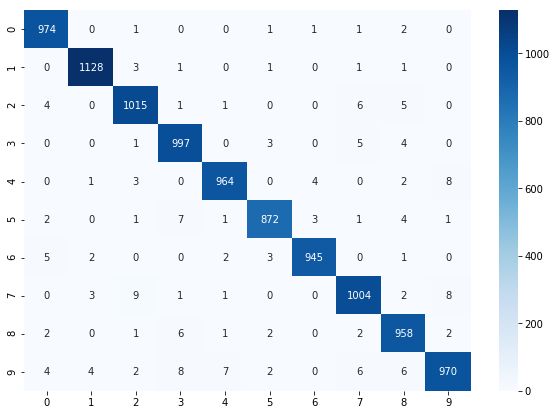

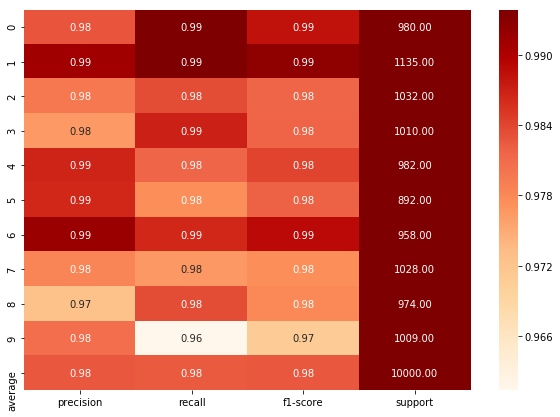

In [77]:
print("==========================")
print("====== MNIST Dataset =====")
print("==========================")


print("Training Accuracy :" + str(support_vector_machine.get_accuracy(TrainingData, TrainingTarget)))
print("Validation Accuracy :" + str(support_vector_machine.get_accuracy(ValidationData, ValidationTarget)))

svm_testing_acc = support_vector_machine.get_accuracy(TestingData, TestingTarget)
print("Testing Accuracy :" + str(svm_testing_acc))


y_pred = support_vector_machine.get_prediction(TestingData)
        
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)





====== USPS Dataset =====
Testing Accuracy :0.2614130706535327


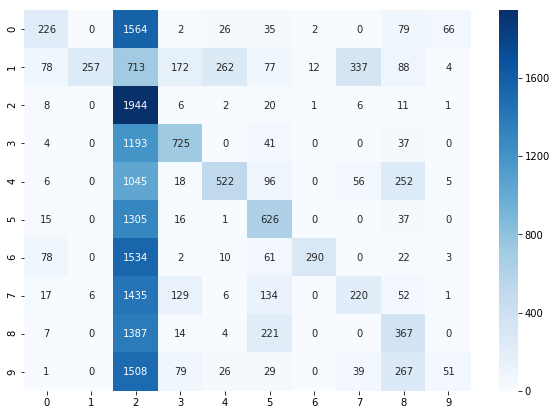

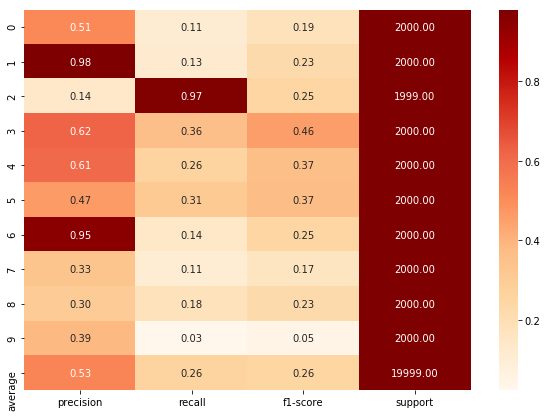

In [78]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")

usps_svm_testing_acc = support_vector_machine.get_accuracy(USPS_Testing_data, USPS_Testing_target)
print("Testing Accuracy :" + str(usps_svm_testing_acc))

y_pred = support_vector_machine.get_prediction(USPS_Testing_data)
        
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Definition: Random Forest 

In [59]:
class RandomForest:
    
    def __init__(self, _n_estimators=100):
        
        self.clf_rf = RandomForestClassifier(n_estimators=_n_estimators)

    def train_model(self, TrainingData, TrainingTarget):
        
        self.clf_rf.fit(TrainingData, TrainingTarget)
        
    def get_prediction(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict(TestingData)
        return y_pred_rf
    
    def get_prediction_probability(self, TestingData):
        
        y_pred_rf = self.clf_rf.predict_proba(TestingData)
        return y_pred_rf
    
    def get_accuracy(self, TestingData, TestingTarget):
        
        y_pred_rf = self.get_prediction(TestingData)
        acc_rf = accuracy_score(TestingTarget, y_pred_rf)
        return acc_rf

In [60]:
rndom_frst = RandomForest(_n_estimators=1000)
rndom_frst.train_model(TrainingData, TrainingTarget)

====== MNIST Dataset =====
Training Accuracy :1.0
Validation Accuracy :0.9734
Testing Accuracy :0.9705


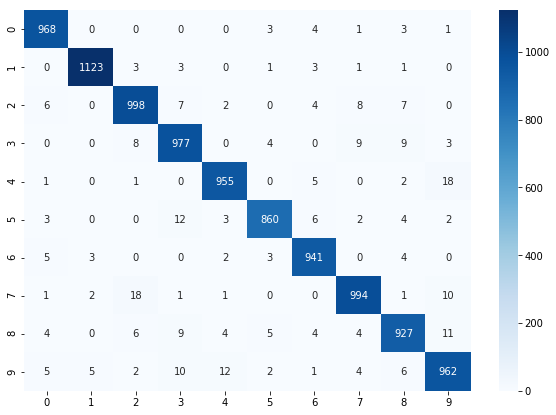

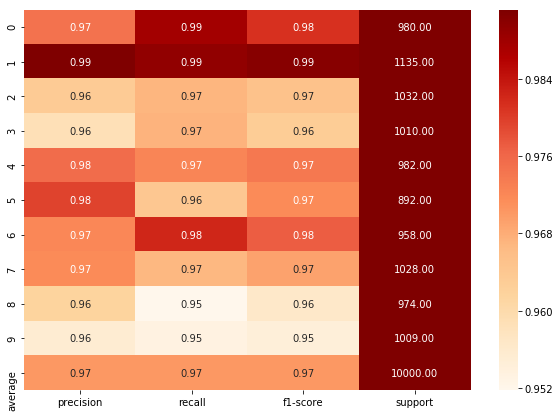

In [79]:
# rndom_frst.get_accuracy(TestingData, TestingTarget)

print("==========================")
print("====== MNIST Dataset =====")
print("==========================")

print("Training Accuracy :" + str(rndom_frst.get_accuracy(TrainingData, TrainingTarget)))
print("Validation Accuracy :" + str(rndom_frst.get_accuracy(ValidationData, ValidationTarget)))

rdf_testing_acc = rndom_frst.get_accuracy(TestingData, TestingTarget)
print("Testing Accuracy :" + str(rdf_testing_acc))

y_pred = rndom_frst.get_prediction(TestingData)
plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)




====== USPS Dataset =====
Testing Accuracy :0.4075203760188009


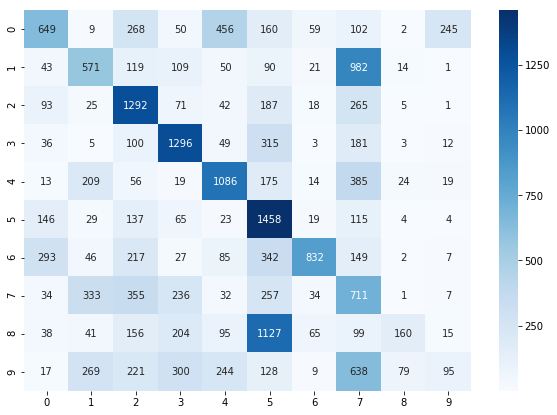

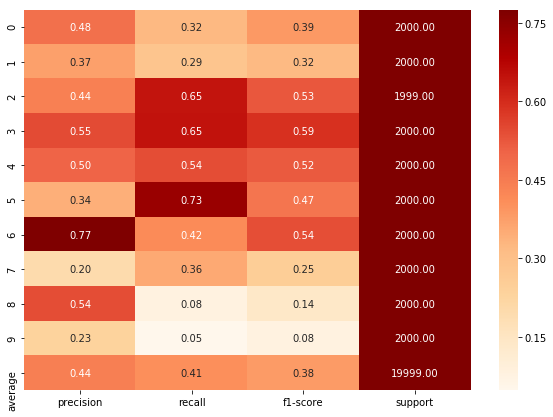

In [80]:
print("=========================")
print("====== USPS Dataset =====")
print("=========================")

usps_rdf_testing_acc = rndom_frst.get_accuracy(USPS_Testing_data, USPS_Testing_target)
print("Testing Accuracy :" + str(usps_rdf_testing_acc))


y_pred = rndom_frst.get_prediction(USPS_Testing_data)       
plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

# Ensemble: Soft Voting

= MNIST Dataset Accuracy =
Accuracy: 0.9804


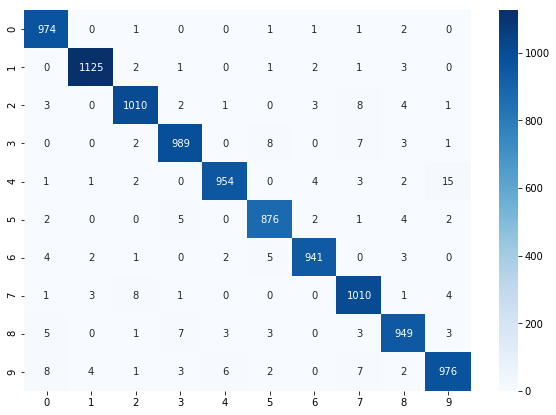

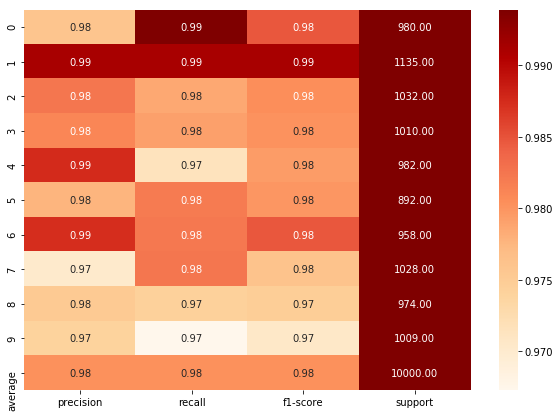

In [81]:
sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(TestingData.T).T
nn_prediction_prob = neural_network.get_prediction_probability(TestingData)
svm_prediction_prob = support_vector_machine.get_prediction_probability(TestingData)
rf_prediction_prob = rndom_frst.get_prediction_probability(TestingData)

# print(sgd_prediction_prob.shape)
# print(nn_prediction_prob.shape)
# print(svm_prediction_prob.shape)
# print(rf_prediction_prob.shape)

sum1 = np.add(nn_prediction_prob,rf_prediction_prob)
sum2 = np.add(sum1,sgd_prediction_prob)
sum3 = np.add(sum2,svm_prediction_prob)

y_pred = sum3.argmax(axis=1)

ens_score = accuracy_score(TestingTarget, y_pred)

print("==========================")
print("= MNIST Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(ens_score))

plot_confusion_matrix(TestingTarget, y_pred)
plot_classification_report(TestingTarget, y_pred)



= USPS Dataset Accuracy =
Accuracy: 0.43862193109655484


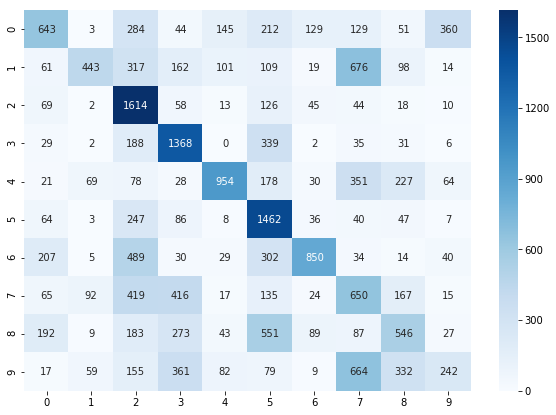

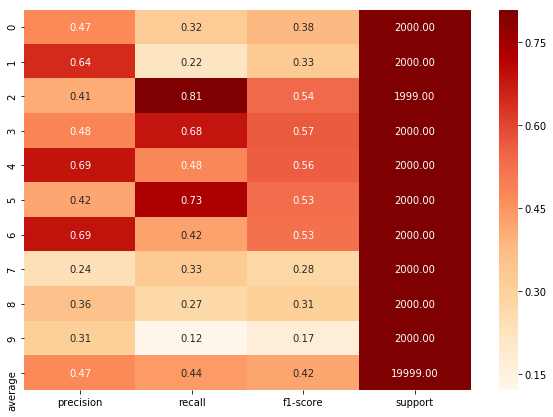

In [82]:
usps_sgd_prediction_prob = mini_batch_sgd.get_prediction_probability(USPS_Testing_data.T).T
usps_nn_prediction_prob = neural_network.get_prediction_probability(USPS_Testing_data)
usps_svm_prediction_prob = support_vector_machine.get_prediction_probability(USPS_Testing_data)
usps_rf_prediction_prob = rndom_frst.get_prediction_probability(USPS_Testing_data)

# print(usps_sgd_prediction_prob.shape)
# print(usps_nn_prediction_prob.shape)
# print(usps_svm_prediction_prob.shape)
# print(usps_rf_prediction_prob.shape)

sum1 = np.add(usps_nn_prediction_prob,usps_rf_prediction_prob)
sum2 = np.add(sum1,usps_sgd_prediction_prob)
sum3 = np.add(sum2,usps_svm_prediction_prob)

y_pred = sum3.argmax(axis=1)
ups_ens_score = accuracy_score(USPS_Testing_target, y_pred)

print("==========================")
print("= USPS Dataset Accuracy =")
print("==========================")
print("Accuracy: " + str(ups_ens_score))


plot_confusion_matrix(USPS_Testing_target, y_pred)
plot_classification_report(USPS_Testing_target, y_pred)

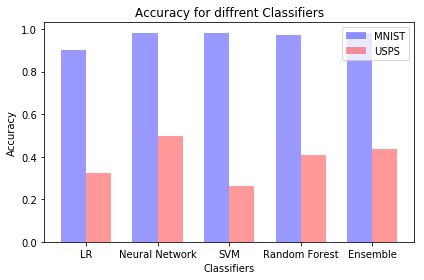

In [94]:
n_groups = 5

means_mnist = (lr_testing_acc/100, nn_testing_acc, svm_testing_acc, rdf_testing_acc, ens_score)


means_usps = (usps_lr_testing_acc/100, usps_nn_testing_acc, usps_svm_testing_acc, usps_rdf_testing_acc, ups_ens_score)


fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, means_mnist, bar_width,
                alpha=opacity, color='b', error_kw=error_config,
                label='MNIST')

rects2 = ax.bar(index + bar_width, means_usps, bar_width,
                alpha=opacity, color='r', error_kw=error_config,
                label='USPS')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy for diffrent Classifiers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('LR', 'Neural Network', 'SVM', 'Random Forest', 'Ensemble'))
ax.legend()

fig.tight_layout()
plt.show()